Импорт библиотек

In [1]:
 # data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

 # visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Загрузка таблиц

In [2]:
train_df = pd.read_csv('train_longevity.csv')
test_df = pd.read_csv('test_longevity.csv')
combine = [train_df, test_df]

Рассмотрим вид загруженных таблиц

In [3]:
display(train_df.head())
train_df.info()

,Id,Longevity,Education,Sex,Age,Pet,Children,Region,Activity,MedExam,Sport
0,1,0,3,female,73,1,0,21,725,NaN,NaN
1,2,1,1,male,75,1,0,17,7128,+,+
2,3,1,3,male,73,0,0,31,793,NaN,NaN
3,4,1,1,male,74,1,0,11,5310,+,NaN
4,5,0,3,female,74,0,0,37,805,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 11 columns):
Id           857 non-null int64
Longevity    857 non-null int64
Education    857 non-null int64
Sex          857 non-null object
Age          680 non-null object
Pet          857 non-null int64
Children     857 non-null int64
Region       857 non-null object
Activity     857 non-null int64
MedExam      196 non-null object
Sport        236 non-null object
dtypes: int64(6), object(5)
memory usage: 73.7+ KB


**В датасетах приведена следующая информация о пожилых людях (атрибуты объекта):**

* Longevity - Класс активного долголетия: 1 - человек доживет до 90 лет; 0 - нет
* Id - Идентификатор пожилого человека;
* Education - Образование: 1 - высшее; 2 - среднее; 3 без образования;
* Sex - Пол;
* Age - Возраст;
* Pet - Пожилой человек ухаживает за домашними животными: указано количество;
* Children - Пожилой человек проживают с детьми/внуками/близкими родственниками: указано количество проживающих совместно в пожилым человеком;
* Region - Регион проживания;
* Activity - Уровень физической активности (количество шагов в день): данные получены от специального приложения;
* MedExam - Посещение поликлиники (за послений год): кодирование посещений на основе заполненной медицинской карточки;
* Sport - Физические упражнения: '+' пожилой человек занимается спортом (ходьба, бег, плаванье); '-' не занимается.

Пропущенные значения в поле `Age` не могут быть заполнены - удаляем их и приводим столбец к целочисленному типу.

In [4]:
# Признак Age должен быть дополнен 
# и фильтрован для обработки алгоритмами.

train_df['Age'].value_counts()
train_df_clean = train_df.dropna(subset=['Age']).reset_index()
train_df_clean = train_df_clean.query('Age != "#ЗНАЧ!"').copy(deep=True)
train_df_clean['Age'] = train_df_clean['Age'].astype('int')

Дропаем ненужное, так как корреляция между параметрами и фактом долголетия маловероятна.

In [5]:
train_df_clean = train_df_clean.drop(['MedExam', 'Region', 'Id'], axis=1)
train_df_clean.head()

,index,Longevity,Education,Sex,Age,Pet,Children,Activity,Sport
0,0,0,3,female,73,1,0,725,NaN
1,1,1,1,male,75,1,0,7128,+
2,2,1,3,male,73,0,0,793,NaN
3,3,1,1,male,74,1,0,5310,NaN
4,4,0,3,female,74,0,0,805,NaN


Если у нас нет информации о том, занимается человек спортом или нет, мы заполняем пропущенные значения '-'.

In [6]:
# Необходимо дополнить функцию Sport, 
# поскольку она также может соотноситься с долголетием.
train_df_clean['Sport'] = train_df_clean['Sport'].fillna(value='-')
train_df_clean.head()

,index,Longevity,Education,Sex,Age,Pet,Children,Activity,Sport
0,0,0,3,female,73,1,0,725,-
1,1,1,1,male,75,1,0,7128,+
2,2,1,3,male,73,0,0,793,-
3,3,1,1,male,74,1,0,5310,-
4,4,0,3,female,74,0,0,805,-


Количество любящих единиц пожилого человека.

In [7]:
# Cоздать новый признак под названием Family 
# (Семья на основе детей и домашних животных), 
# чтобы получить общее количество членов семьи.
train_df_clean['Family'] = train_df_clean['Children'] + train_df_clean['Pet']

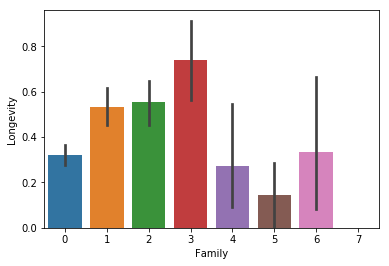

In [8]:
sns.barplot(data=train_df_clean, x='Family', y='Longevity')

График может говорить о следующем: с ростом количества голов в семье количество долгожителей в группе увеличивается, однако по достижению критического количества социальная нагрузка (и уровень стресса) пожилого человека становится слишком большой - и количество долгожителей начинает уменьшаться. Однако, выводы преждевременные.

Признак: нет никого, кто любит пожилого человека.

In [9]:
# Заздать новый признак IsAlone, 
# проживающих одиноко без домашних животных и родственников.
train_df_clean['IsAlone'] = (train_df_clean['Family'] == 0)

Превращаем количественную переменную в категориальню - вводим порядковый номер диапазона возрастного равновесия.

In [10]:
# Cоздать новый признак диапазонов возрасного равновесия 
# на основе признака Age, т.к. это поможет разделить пожилых 
# людей на группы условно равновесного состояния 
# (смертность повышается в определенные периоды времени 
# между 70 и 80 годами, и в другие моменты резко снижается) 
# для следующих интервалов: 
# { (...,70](70,72],(72,74],(74,76],(76,78],(80,..)}

def age_range(age):
    if (age <= 70):
        return 1;
    if (age <= 72):
        return 2;
    if (age <= 74):
        return 3;
    if (age <= 76):
        return 4;
    if (age <= 78):
        return 5;
    return 6;
    
train_df_clean['Age_range'] = train_df_clean['Age'].apply(age_range)

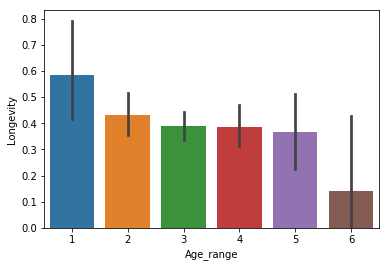

In [11]:
sns.barplot(data=train_df_clean, x='Age_range', y='Longevity')

Из графика видно, что количество долгожителей обратно пропорционально порядковому номеру равновесной возрастной группы. Иначе говоря, смертность увеличивается с ростом возраста.

In [12]:
# Cоздать новый признак для возрастных групп (Age,Education), 
# указывающий на социальный статус пожилого человека. 
# Это превращает непрерывный числовой признак в порядковый 
# категориальный признак.

train_df_clean['Social_status'] = train_df_clean['Age_range'] * train_df_clean['Education']

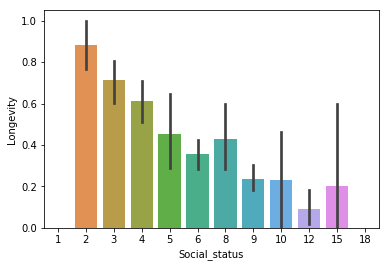

In [13]:
sns.barplot(data=train_df_clean, x='Social_status', y='Longevity')

Социальный статус - произведение возраста на образование, упорядочивает пожилых людей по снижению дееспособности и снижению квалификации, по типу (дееспособные, квалифицированные), (недееспособные, квалифицированные), (недееспособные, неквалифицированные) c **увеличением** параметра social_status.  
Из графика наблюдается общая тендеция к снижению количества долгожителей с ухудшением социального статуса.

Приведем поле `sport` к целочисленному значению для упрощения дальнейшей работы.

In [14]:
train_df_clean['Sport'] = (train_df_clean['Sport'] == '+').astype('int')

Рассмотрим итоговую таблицу.

In [15]:
display(train_df_clean.head())
train_df_clean.info()

,index,Longevity,Education,Sex,Age,Pet,Children,Activity,Sport,Family,IsAlone,Age_range,Social_status
0,0,0,3,female,73,1,0,725,0,1,False,3,9
1,1,1,1,male,75,1,0,7128,1,1,False,4,4
2,2,1,3,male,73,0,0,793,0,0,True,3,9
3,3,1,1,male,74,1,0,5310,0,1,False,3,3
4,4,0,3,female,74,0,0,805,0,0,True,3,9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 679 entries, 0 to 679
Data columns (total 13 columns):
index            679 non-null int64
Longevity        679 non-null int64
Education        679 non-null int64
Sex              679 non-null object
Age              679 non-null int64
Pet              679 non-null int64
Children         679 non-null int64
Activity         679 non-null int64
Sport            679 non-null int64
Family           679 non-null int64
IsAlone          679 non-null bool
Age_range        679 non-null int64
Social_status    679 non-null int64
dtypes: bool(1), int64(11), object(1)
memory usage: 89.6+ KB


In [16]:
#import csv
file = open("Day2_df.csv", 'w', encoding = 'utf-8', newline = '')
#writer = csv.writer(file)
#writer.writerows(train_df_clean)
train_df_clean.to_csv(file)
file.close()
type(train_df_clean)

pandas.core.frame.DataFrame

Сохраним готовый датафрейм в csv-файл

In [17]:
file = open("Day2_df.csv", 'w', encoding = 'utf-8', newline = '')
#type(train_df_clean) # Type is pandas.DataFrame; So, we can use the following method
train_df_clean.to_csv(file)
file.close()
